## ДЗ7



Цель задания:
Познакомится с алгоритмами metric learning

Описание задания:
В рамках данного домашнего задания предлагается решить задачу поиска похожего автомобиля в базе данных (автомобиля того же класса). На основе датасета cars196 , ссылка на данные мета data.

Процесс выполнения задания следующий:

Выбор модели эмбеддера:

Выберите модель кодирующую изображения для выполнения домашнего задания. Любую, кроме модели resnet50.
Подготовка обучающего набора данных

Реализуйте корректный класс Dataset и Dataloader для выбранной модели (должен работать форвард вашей модели на том, что выходит из даталоадера).
Добавьте аугментации в датасет 0.5 балла.
Реализация корректного train-loop и обучение модели:

Реализуйте train-loop для вашей модели и проведите обучение c Triplet loss 2 балла.
При формировании триплета не просто брать отрицательный класс, а воспользоваться техникой hard negative mining 0.5 балла.
Обучите модель и воcпользуйте иными loss функциями для задачи metric learning 0.5 балла.
Полезные ссылки тык
Валидация обученных моделей на тестовой выборке, вычисление метрики Recall и Precision

Оцените качество моделей на тестовой части данных и рассчитайте метрики поиска Recall@1, Recall@5, Precision@1, Precision@5. Обратите внимание, что для формирования предсказаний на тестовой выборке вы не должны предсказывать напрямую класс объекта, а должны производить поиск на основе получившихся эмбеддингов (пример в семинаре блок Faiss). 0.5 балла
При поиске воспользоваться библиотекой Faiss 0.5 балла
Выводы:

Проанализируйте результаты обучения, визуально оцените качество работы модели.
Прокомментируйте распространенные ошибки модели и предложите пути для улучшения финального решения.
Проинтерпретируйте результаты работы модели с помощью GradCam 0.5 балла

In [14]:
import cv2
import os
import matplotlib.pyplot as plt
import random
import pandas as pd
import numpy as np
import tqdm
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import scipy.io

DEVICE=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mat = scipy.io.loadmat('C:\\Users\\Alex\\Downloads\\devkit\\devkit\\cars_train_annos.mat')
fname_to_class = {fname:cl-1 for fname, cl in zip([i[0] for i in mat['annotations'][0]['fname']], 
                                                [i[0][0] for i in mat['annotations'][0]['class']])}
cars_meta = scipy.io.loadmat('C:\\Users\\Alex\\Downloads\\devkit\\devkit\\cars_meta.mat')
id_to_car = {idx: car[0] for idx, car in enumerate(cars_meta['class_names'][0])}

items = list(fname_to_class.items())
random.shuffle(items)

train_items = items[:int(len(items) * 0.8)]
val_items = items[int(len(items) * 0.8):]
train_imgs = np.array([item[0] for item in train_items])
train_ids = np.array([item[1] for item in train_items])
val_imgs = np.array([item[0] for item in val_items])
val_ids = np.array([item[1] for item in val_items])

 # Реализация датасета с возможностью mining для TripletLoss

In [18]:
MARGIN = 0.2
num_classes=192

def distance(x1, x2):
    return (x1 - x2).pow(2).sum(1).to('cpu')

class TripletDataset(torch.utils.data.Dataset):
    def __init__(self, imgs, ids, transforms,  model=None, triplet_margin=MARGIN):
        self.cars = np.vstack([imgs, ids])
        self.model = model
        if model:
            self.margin = triplet_margin
        self.transforms = transforms
        
    def __len__(self):
        return self.cars.shape[1]
    
    def positive(self, anchor_id, anchor_filename):
        positives = self.cars[:, self.cars[1] == anchor_id]
        positives = positives[:, positives[0] != anchor_filename]
        random_idx = random.randint(0, positives.shape[1] - 1)
        return positives[0, random_idx], positives[1, random_idx]        
    
    def negative(self, anchor_id, anchor_embedding=None, positive_embedding=None):      
        
        if self.model is None: # без hard mining
            negatives = self.cars[:, self.cars[1] != anchor_id]
            random_idx = random.randint(0, negatives.shape[1] - 1)
            return negatives[0, random_idx], negatives[1, random_idx]


        #в качестве hard mining рандомно выбираем 1 представителя от каждого класса, 
        #считаем расстояние до этих представителей пока не выполнится условие dist_anchor_to_negative < dist_anchor_to_positive
        #при этом обновляем минимальный найденный dist_anchor_to_negative. 
        #Возвращаем негативный элемент соответствующий минимальному dist_anchor_to_negative.
        
        min_dist=0
        min_idx=0
        min_filename=0
        dist_anchor_to_positive = distance(anchor_embedding, positive_embedding)
        for i in range(num_classes):
            if(i!=anchor_id):
                temp=self.cars[:, self.cars[1] == i]
                random_id = random.randint(0,temp.shape[1] - 1)
                negative_filename = temp[0, random_id]
                negative_id = temp[1, random_id]
                negative_image = cv2.imread(os.path.join('C:\\Users\\Alex\\Downloads\\devkit\\devkit\\cars_train\\cars_train', negative_filename))
                negative_image = cv2.cvtColor(negative_image, cv2.COLOR_BGR2RGB)
                with torch.no_grad():
                    negative_embedding = self.model(self.transforms(negative_image).to(DEVICE))
                dist_anchor_to_negative = distance(anchor_embedding, negative_embedding)    
                
                if(dist_anchor_to_negative<min_dist):
                    min_dist=dist_anchor_to_negative
                    min_filename= negative_filename
                    min_idx= negative_id
                    
                if dist_anchor_to_negative < dist_anchor_to_positive:
                    return negative_filename, negative_id
        
        
        return min_filename, min_idx
            
            
    def __getitem__(self, idx):
        anchor_filename, anchor_id = self.cars[0, idx], self.cars[1, idx]
        anchor_image = cv2.imread(os.path.join('C:\\Users\\Alex\\Downloads\\devkit\\devkit\\cars_train\\cars_train', anchor_filename))
        anchor_image = cv2.cvtColor(anchor_image, cv2.COLOR_BGR2RGB)
        positive_filename = self.positive(anchor_id, anchor_filename)[0]
        positive_image = cv2.imread(os.path.join('C:\\Users\\Alex\\Downloads\\devkit\\devkit\\cars_train\\cars_train', positive_filename))
        positive_image = cv2.cvtColor(positive_image, cv2.COLOR_BGR2RGB)
        
        if self.model is None:
            negative_filename = self.negative(anchor_id)[0]
        else:
            self.model.eval()
            with torch.no_grad():
                anchor_embedding = self.model(self.transforms(anchor_image).to(DEVICE))
                positive_embedding = self.model(self.transforms(positive_image).to(DEVICE))
            
            negative_filename = self.negative(anchor_id, anchor_embedding, positive_embedding)[0]
            
        
        negative_image = cv2.imread(os.path.join('C:\\Users\\Alex\\Downloads\\devkit\\devkit\\cars_train\\cars_train', negative_filename))
        negative_image = cv2.cvtColor(negative_image, cv2.COLOR_BGR2RGB) 

        if self.transforms:
            anchor_image = self.transforms(anchor_image)
            positive_image = self.transforms(positive_image)
            negative_image = self.transforms(negative_image)
        return {'anchor_image': anchor_image, 'positive_image': positive_image, 'negative_image': negative_image}



class SimpleDataset(torch.utils.data.Dataset):
    def __init__(self, imgs, ids, transforms):
        self.cars = np.vstack([imgs, ids])
        self.transforms = transforms
        
    def __len__(self):
        return self.cars.shape[1]

    def __getitem__(self, idx):
        filename, cl_id = self.cars[:, idx]
        image = cv2.imread(os.path.join('C:\\Users\\Alex\\Downloads\\devkit\\devkit\\cars_train\\cars_train', filename))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transforms:
            image = self.transforms(image)
        sample = {'image': image, 'label': cl_id}
        return sample

# Embeding c TripletLoss

In [16]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks import LearningRateMonitor
from torchvision.models import squeezenet1_1,SqueezeNet1_1_Weights, swin_t, Swin_T_Weights
from torch.nn import TripletMarginLoss
import torchvision.models as models
los=[]

class Embeding(pl.LightningModule):
    def __init__(self, class_dict, learning_rate, emb_size, triplet_margin=MARGIN):
        super().__init__()
        self.learning_rate = learning_rate
        self.model = swin_t(weights=Swin_T_Weights)
        self.model.head= torch.nn.Sequential(
                            torch.nn.Linear(in_features=768, out_features=512))
        self.triplet_loss =nn.TripletMarginLoss(margin=0.2)
        
        
    def training_step(self, batch, batch_idx):
        anchor_imgs = batch['anchor_image']
        positive_imgs = batch['positive_image']
        negative_imgs = batch['negative_image'] 
        anchor_emb = self.model(anchor_imgs)
        self.model.eval()
        with torch.no_grad():
            positive_emb = self.model(positive_imgs)
            negative_emb = self.model(negative_imgs)
        
        self.model.train()
        loss = self.triplet_loss(anchor_emb, positive_emb, negative_emb).mean()
       
        return loss
    
    def validation_step(self, batch, batch_idx):
        global los
        anchor_imgs = batch['anchor_image']
        positive_imgs = batch['positive_image']
        negative_imgs = batch['negative_image']
        
        anchor_emb = self.model(anchor_imgs)
        positive_emb = self.model(positive_imgs)
        negative_emb = self.model(negative_imgs)
        
        loss = self.triplet_loss(anchor_emb, positive_emb, negative_emb).mean()
        los.append(loss)
        
        
    def forward(self, images):
        if len(images.shape) == 4:
            preds = self.model(images) 
        else:
            preds = self.model(images.unsqueeze(0))
        return preds
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return [optimizer]

# Обучение:

In [4]:
train_transforms = torchvision.transforms.Compose([
            torchvision.transforms.ToPILImage(), 
            torchvision.transforms.Resize(
                size=(256, 256)
            ),
            torchvision.transforms.ToTensor(),  
            torchvision.transforms.RandomAffine(degrees=(-10, 10), translate=(0.1, 0.1)),
            torchvision.transforms.RandomPerspective(distortion_scale=0.2),
            torchvision.transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )
            ])


val_transforms = torchvision.transforms.Compose([
            torchvision.transforms.ToPILImage(), 
            torchvision.transforms.Resize(
                size=(256, 256)
            ),
            torchvision.transforms.ToTensor(),  
            torchvision.transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )
            ])

train_dataset = TripletDataset(train_imgs, train_ids, train_transforms)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True,  pin_memory=True, drop_last = True)

pl_model = Embeding(id_to_car, 3e-4, 512, MARGIN)
pl_model.to(DEVICE)
pl_model.train()
val_dataset = TripletDataset(val_imgs, val_ids, val_transforms)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, pin_memory=True)



C:\Users\Alex\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Swin_T_Weights.IMAGENET1K_V1`. You can also use `weights=Swin_T_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [24]:
trainer.validate(model=pl_model, dataloaders=val_loader)
print("val loss before training", np.mean(np.array(los)))

Validation: |                                                                                    | 0/? [00:00<…

val loss before training 0.23598453


In [25]:
trainer = pl.Trainer(max_epochs = 4, accelerator=device)
trainer.fit(model=pl_model, train_dataloaders=train_loader, val_dataloaders=val_loader)
trainer.validate(model=pl_model, dataloaders=val_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type              | Params | Mode 
-----------------------------------------------------------
0 | model        | SwinTransformer   | 27.9 M | train
1 | triplet_loss | TripletMarginLoss | 0      | eval 
-----------------------------------------------------------
27.9 M    Trainable params
0         Non-trainable params
27.9 M    Total params
111.652   Total estimated model params size (MB)
181       Modules in train mode
1         Modules in eval mode


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=4` reached.


Validation: |                                                                                    | 0/? [00:00<…

[{}]

In [26]:
los=np.array(los)
print(los.shape)
print('val loss after training', np.mean(los[int(los.shape[0]-los.shape[0]/4):]))

(927,)
val loss after training 0.19994873


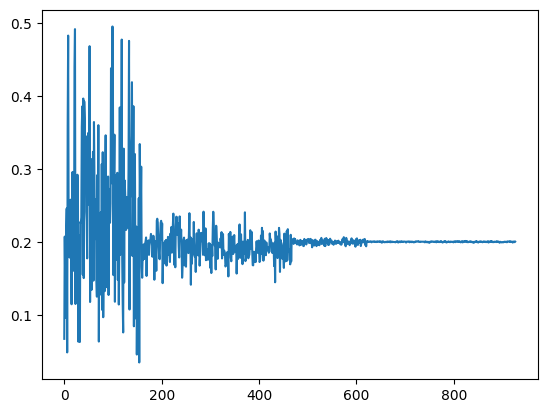

In [27]:
plt.plot(los)

## Precision@k, Recall@k

In [14]:
def precision_k(labels, embeds, index, k):
    Distances, Indexes = index.search(embeds, k)
    predicted_labels = train_labels[Indexes.flatten()]
    return np.sum([labels[i] in predicted_labels[i * k : (i+1) * k] for i in range(labels.shape[0])]) / (labels.shape[0] * k)

def recall_k(labels, embeds, index, k):
    Distances, Indexes = index.search(embeds, k)
    predicted_labels = train_labels[Indexes.flatten()]
    return np.sum([labels[i] in predicted_labels[i * k : (i+1) * k] for i in range(labels.shape[0])]) / labels.shape[0]

# Поиск похожих машин с Faiss


In [28]:
train_dataset = SimpleDataset(train_imgs, train_ids, val_transforms)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True,  pin_memory=True, drop_last = True)

val_dataset = SimpleDataset(val_imgs, val_ids, val_transforms)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, pin_memory=True)


def embed(model, loader):
    embeddings = np.empty((1,512))
    labels = np.empty((1))
    for batch in loader:
        imgs = batch['image']
        label = batch['label']
        pl_model.to(DEVICE)
        with torch.no_grad():
            preds = model(imgs.to(DEVICE))
        embeddings = np.concatenate([embeddings, preds.cpu().numpy()])
        labels = np.concatenate([labels, np.array(label)])
    return embeddings[1:].astype(np.float32), labels[1:]

pl_model.eval()
train_emb, train_labels = embed(pl_model, train_loader)
val_emb, val_labels = embed(pl_model, val_loader)

In [29]:
import faiss     
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

index = faiss.IndexFlatL2(512)   
index.add(train_emb)                

for k in [1,5]:
    print(f'Recall @ {k} : {recall_k(val_labels, val_emb, index, k)}')
    print(f'Precision @ {k} : {precision_k(val_labels, val_emb, index, k)}')

Recall @ 1 : 0.004909983633387889
Precision @ 1 : 0.004909983633387889
Recall @ 5 : 0.02495908346972177
Precision @ 5 : 0.004991816693944354
